# Import libraries

In [1]:
import os
os.chdir('/home/wcx/gitProject/evoxbench/evoxbench_submit/c10mop2')

import pickle
import random
import numpy as np
import pandas as pd
from easydict import EasyDict as edict
from benchmark_c10_mop2 import C10MOPProblem, c10mop

Auto Configuration Succeed!, Using database /home/wcx/gitProject/evoxbench/database/database.
Auto Configuration Succeed!, Using database /home/wcx/gitProject/evoxbench/database/database.
['/home/wcx/gitProject/evoxbench/evoxbench_submit', '/sdb_new/gitProject/evoxbench/evoxbench_submit/c10mop2', '/home/wcx/anaconda3/envs/evoxbench/lib/python38.zip', '/home/wcx/anaconda3/envs/evoxbench/lib/python3.8', '/home/wcx/anaconda3/envs/evoxbench/lib/python3.8/lib-dynload', '', '/home/wcx/.local/lib/python3.8/site-packages', '/home/wcx/anaconda3/envs/evoxbench/lib/python3.8/site-packages', '/home/wcx/gitProject/evoxbench/database/database', '/home/wcx/gitProject/evoxbench/database/database']


In [2]:
pid = 2
args = edict()
args.checkpoint = True
args.seed = 2023
args.run = 1
# set seed
random.seed(args.seed)
np.random.seed(args.seed)

In [3]:
benchmark = c10mop(pid)
problem = C10MOPProblem(benchmark)

# Divide the dataset

In [4]:
d = './'
obj_d = d + 'train_data_50000.pkl'
search_space = benchmark.search_space
evaluator = benchmark.evaluator
if not os.path.exists(obj_d):
    archs = np.array(search_space.sample(50000))
    X = search_space.encode(archs)
    fine_idx = problem._get_fine_x(X)
    X, archs = X[fine_idx], archs[fine_idx]
    y = evaluator.evaluate(archs, true_eval=True)
    pickle.dump((X, y), open(obj_d, 'wb')) 
    whole_x, whole_y = X.copy(), y.copy()
else:
    X, y = pickle.load(open(obj_d, 'rb'))
    whole_x, whole_y = X.copy(), y.copy()

In [5]:
len(X)

6760

<AxesSubplot: ylabel='Count'>

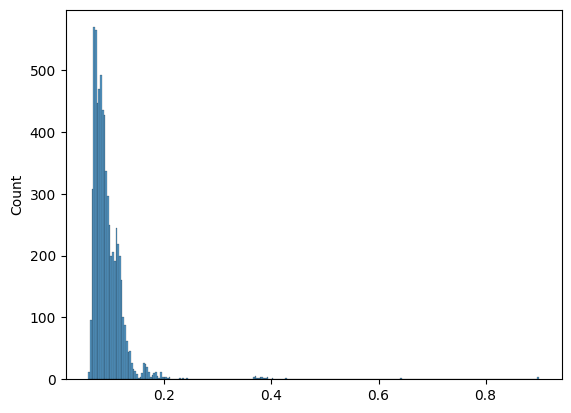

In [6]:
import seaborn as sns
sns.histplot([i['err'] for i in y])

# train the dataset using 2000 archs

In [7]:
def aux(train_x, train_y):
    import numpy as np
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    from catboost import CatBoostRegressor, Pool
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=2023)

    models, errs = [], []
    X, y = train_x, train_y
    for train_idx, test_idx in kfold.split(X, y):
        model = CatBoostRegressor(iterations=10000, learning_rate=0.1, depth=6, random_seed=2023,
                                loss_function='RMSE', verbose=True, early_stopping_rounds=1000)
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model.fit(X_train, y_train, eval_set=Pool(X_test, y_test), use_best_model=True, verbose=500)
        
        y_pred = model.predict(X_test)
        models.append(model)
        
        err = mean_squared_error(y_test, y_pred)
        errs.append(err)

    return models, errs

In [8]:
train_len = 2000
train_x, train_y = X[:train_len], y[:train_len]
test_x, test_y = X[train_len:], y[train_len:]
print('train data shape: ', train_x.shape, '\ntest data shape: ', test_x.shape)

trn_x = train_x
trn_y = np.array([i['err'] for i in train_y])
tst_x = test_x
tst_y = np.array([i['err'] for i in test_y])
err_models, mse_errs = aux(trn_x, trn_y)

train data shape:  (2000, 26) 
test data shape:  (4760, 26)
0:	learn: 0.0332762	test: 0.0306977	best: 0.0306977 (0)	total: 51ms	remaining: 8m 29s
500:	learn: 0.0053559	test: 0.0261385	best: 0.0247691 (78)	total: 785ms	remaining: 14.9s
1000:	learn: 0.0015432	test: 0.0264978	best: 0.0247691 (78)	total: 1.48s	remaining: 13.3s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.02476912932
bestIteration = 78

Shrink model to first 79 iterations.
0:	learn: 0.0328663	test: 0.0320023	best: 0.0320023 (0)	total: 3.8ms	remaining: 38s
500:	learn: 0.0053162	test: 0.0268027	best: 0.0263924 (150)	total: 695ms	remaining: 13.2s
1000:	learn: 0.0015498	test: 0.0269457	best: 0.0263924 (150)	total: 1.38s	remaining: 12.4s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.02639240755
bestIteration = 150

Shrink model to first 151 iterations.
0:	learn: 0.0327472	test: 0.0332730	best: 0.0332730 (0)	total: 3.77ms	remaining: 37.7s
500:	learn: 0.0053352	test: 0.0278296	best:

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
pred_y_list = []
for model in err_models:
    pred_y = model.predict(test_x)
    pred_y_list.append(pred_y)
pred_y = np.array(pred_y_list).mean(axis=0)
mse_err = mean_squared_error(tst_y, pred_y)
mae_err = mean_absolute_error(tst_y, pred_y)
print('mse_err: ', mse_err, '\nmae_err: ', mae_err)

mse_err:  0.0014071625450391009 
mae_err:  0.013426754309299857


(0.0, 35.0)

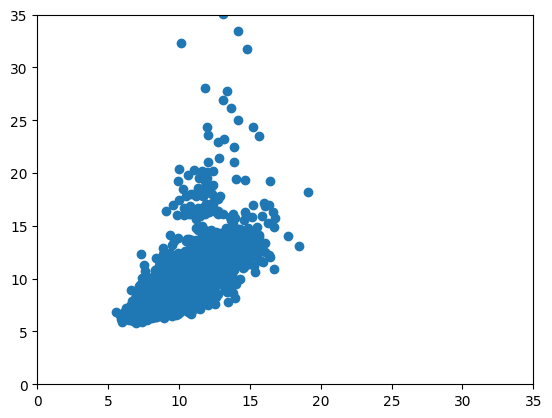

In [10]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

comp = pd.DataFrame({'pred': pred_y, 'true': tst_y})
plt.scatter(comp['pred']*100, comp['true']*100)
plt.xlim(0, 35)
plt.ylim(0, 35)

In [11]:
def get_pred_err(X):
    pred_y_list = []
    for model in err_models:
        pred_y = model.predict(X)
        pred_y_list.append(pred_y)
    return np.array(pred_y_list).mean(axis=0)

In [12]:
get_pred_err(test_x[:10])

array([0.11263227, 0.0921772 , 0.06784404, 0.08877802, 0.11495947,
       0.09814204, 0.07489601, 0.1138504 , 0.09017071, 0.07096976])

# Get the params and flops

In fact, in neural architecture search problems, the number of parameters and flops is not an expensive task and can be obtained directly.

In [13]:
utopian = benchmark.utopian_point
nadir = benchmark.nadir_point
def get_pred_params_direct(X):
    return benchmark.evaluate(X)[:, 1]* (nadir[1] - utopian[1]) + utopian[1]
def get_pred_flops_direct(X):
    return benchmark.evaluate(X)[:, 2]* (nadir[2] - utopian[2]) + utopian[2]

In [14]:
get_pred_params_direct(test_x[:10]), get_pred_flops_direct(test_x[:10])

(array([ 1290895.,  5793546.,  8992394.,  5039754.,  3468426.,  4426762.,
         8118666.,  2277770., 12088970.,  5532810.]),
 array([4.05775690e+08, 1.71398964e+09, 2.65914983e+09, 1.51025460e+09,
        1.03416833e+09, 1.31697255e+09, 2.39346689e+09, 6.99312138e+08,
        3.57096859e+09, 1.63814811e+09]))

# A binary classifier to filter good architectures

In [15]:
train_x, train_y = X[:train_len], y[:train_len]
test_x, test_y = X[train_len:], y[train_len:]
print('train data shape: ', train_x.shape, '\ntest data shape: ', test_x.shape)

trn_x = train_x
trn_y = np.array([i['err'] for i in train_y])
trn_y = np.array([1 if i <= 0.09 else 0 for i in trn_y])
tst_x = test_x
tst_y = np.array([i['err'] for i in test_y])
tst_y = np.array([1 if i <=0.09 else 0 for i in tst_y])

train data shape:  (2000, 26) 
test data shape:  (4760, 26)


In [16]:
def aux(train_x, train_y):
    import numpy as np
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    from catboost import CatBoostRegressor, Pool, CatBoostClassifier
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=2023)

    models, accs = [], []
    X, y = train_x, train_y
    for train_idx, test_idx in kfold.split(X, y):
        model = CatBoostClassifier(iterations=10000, learning_rate=0.1, depth=6, random_seed=2023,
                                    early_stopping_rounds=500, loss_function='Logloss')
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model.fit(X_train, y_train, eval_set=Pool(X_test, y_test), use_best_model=True, verbose=500)
        
        y_pred = model.predict(X_test)
        models.append(model)
        accs.append((y_pred == y_test).mean())

    return models, accs

In [17]:
pd_91_models, accs = aux(trn_x, trn_y)

0:	learn: 0.6365725	test: 0.6391618	best: 0.6391618 (0)	total: 4.06ms	remaining: 40.6s
500:	learn: 0.0079404	test: 0.3678919	best: 0.3304213 (173)	total: 1.03s	remaining: 19.5s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.330421301
bestIteration = 173

Shrink model to first 174 iterations.
0:	learn: 0.6472388	test: 0.6498111	best: 0.6498111 (0)	total: 3.86ms	remaining: 38.6s
500:	learn: 0.0080669	test: 0.3485663	best: 0.3108664 (223)	total: 1.03s	remaining: 19.6s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.3108663527
bestIteration = 223

Shrink model to first 224 iterations.
0:	learn: 0.6407582	test: 0.6439322	best: 0.6439322 (0)	total: 3.22ms	remaining: 32.2s
500:	learn: 0.0079888	test: 0.3435697	best: 0.3029046 (175)	total: 1.02s	remaining: 19.3s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.3029045997
bestIteration = 175

Shrink model to first 176 iterations.
0:	learn: 0.6479306	test: 0.6501286	best: 0.6501286 (

In [18]:
accs

[0.8475, 0.8725, 0.865, 0.8675, 0.8425]

In [19]:
def pd_X_more_than_91(X):
    pred_y_list = []
    for model in pd_91_models:
        pred_y = model.predict(X)
        pred_y_list.append(pred_y)
    return np.around(np.array(pred_y_list).mean(axis=0))

In [20]:
pd_X_more_than_91(X)

array([0., 1., 0., ..., 0., 0., 0.])

In [21]:
import pickle
pickle.dump(pd_91_models, open('pd_91_models_2000.pkl', 'wb'))
pickle.dump(err_models, open('err_models_2000.pkl', 'wb'))

# Combine models to predict the performance

In [22]:
pd_X = pd_X_more_than_91(test_x)
filter_x = test_x[pd_X == 1]
filter_y = np.array(test_y)[pd_X == 1]
y_err = np.array([i['err'] for i in filter_y])

In [23]:
pred_y = get_pred_err(filter_x)
mse_err = mean_squared_error(y_err, pred_y)
mae_err = mean_absolute_error(y_err, pred_y)
print('mse_err: ', mse_err, '\nmae_err: ', mae_err)

mse_err:  0.00020154272618570933 
mae_err:  0.009293154894283435


In [24]:
def get_end_acc(X):
    pd = pd_X_more_than_91(X)
    if pd == 1:
        return 1-get_pred_err(X)
    else:
        return None

In [25]:
get_end_acc(X[10])

0.9138316721452948